In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/LDS9_K265_TranHoangBach_Cuoi_ky'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_K265_TranHoangBach/LDS9_K265_TranHoangBach_Cuoi_ky


In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

%matplotlib inline

In [4]:
spark = SparkSession \
            .builder \
            .master("local[*]")\
            .appName("New-Spark") \
            .config("spark.memory.fraction", 0.8) \
            .config("spark.executor.memory", "10g") \
            .config("spark.driver.memory", "10g")\
            .config("spark.sql.shuffle.partitions" , "800") \
            .config("spark.memory.offHeap.enabled",'true')\
            .config("spark.memory.offHeap.size","10g")\
            .getOrCreate()
spark

Vì khi thực hiện đọc data này trực tiếp bằng spark bị lỗi, nên chuyển sang đọc bằng pandas trước rồi tạo Schema đọc bằng spark

In [5]:
data = pd.read_csv('data/cbc-news-coronavirus-articles-march-26/news.csv', index_col=0)
data.head()

,authors,title,publish_date,description,text,url
0,['Cbc News'],Coronavirus a 'wake-up call' for Canada's pres...,2020-03-27 08:00:00,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,https://www.cbc.ca/news/health/covid-19-drug-s...
1,['Cbc News'],Yukon gov't names 2 possible sources of corona...,2020-03-27 01:45:00,The Yukon government has identified two places...,The Yukon government has identified two places...,https://www.cbc.ca/news/canada/north/yukon-cor...
2,['The Associated Press'],U.S. Senate passes $2T coronavirus relief package,2020-03-26 05:13:00,The Senate has passed an unparalleled $2.2 tri...,The Senate late Wednesday passed an unparallel...,https://www.cbc.ca/news/world/senate-coronavir...
3,['Cbc News'],Coronavirus: The latest in drug treatment and ...,2020-03-27 00:36:00,Scientists around the world are racing to find...,Scientists around the world are racing to find...,https://www.cbc.ca/news/health/coronavirus-tre...
4,['Cbc News'],The latest on the coronavirus outbreak for Mar...,2020-03-26 20:57:00,The latest on the coronavirus outbreak from CB...,Trudeau says rules of Quarantine Act will ...,https://www.cbc.ca/news/the-latest-on-the-coro...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3566 entries, 0 to 4608
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   authors       3566 non-null   object
 1   title         3566 non-null   object
 2   publish_date  3566 non-null   object
 3   description   3566 non-null   object
 4   text          3566 non-null   object
 5   url           3566 non-null   object
dtypes: object(6)
memory usage: 195.0+ KB


In [7]:
data['publish_date'] = pd.to_datetime(data['publish_date'])

Thông qua data.info và dtype ta tạo schema cho pyspark dataframe

In [53]:
schema = StructType([StructField("authors", StringType(), False), 
                     StructField("title", StringType(), False),
                     StructField("publish_date", DateType(), False),
                     StructField("description", StringType(), False),
                     StructField("text", StringType(), False),
                     StructField("url", StringType(), False),
])
df = spark.createDataFrame(data, schema=schema)
df.show(5)

+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|             authors|               title|publish_date|         description|                text|                 url|
+--------------------+--------------------+------------+--------------------+--------------------+--------------------+
|        ['Cbc News']|Coronavirus a 'wa...|  2020-03-27|Canadian pharmaci...|Canadian pharmaci...|https://www.cbc.c...|
|        ['Cbc News']|Yukon gov't names...|  2020-03-27|The Yukon governm...|The Yukon governm...|https://www.cbc.c...|
|['The Associated ...|U.S. Senate passe...|  2020-03-26|The Senate has pa...|The Senate late W...|https://www.cbc.c...|
|        ['Cbc News']|Coronavirus: The ...|  2020-03-27|Scientists around...|Scientists around...|https://www.cbc.c...|
|        ['Cbc News']|The latest on the...|  2020-03-26|The latest on the...|    Trudeau says ...|https://www.cbc.c...|
+--------------------+------------------

In [26]:
df.count()

3566

In [27]:
print('Number of Null values')
for col_name in df.columns:
    print('\t -', col_name, ": ", df.where(df[col_name].isNull()).count())

Number of Null values
	 - authors :  0
	 - title :  0
	 - publish_date :  0
	 - description :  0
	 - text :  0
	 - url :  0


Nhận xét:
- Bài toán đặt ra thuộc nhóm Clustering - News.
- Các biến input phần lớn là NLP, nên cần tập trung xử lý NLP
- Khi sử dụng tokenizer để xử lý text, thì function đã tự convert lowercase, chỉ cần pre-processing bỏ bớt các ký tự đặc biệt là đủ.
- Bài toán Clustering nên mục đích chính là để đi phân cụm các tin tức thành các nhóm cho phù hợp, từ đó xem có những đặc điểm gì nổi bậc ở các nhóm hay không, các nhóm có phân cụm các tin tức như cách phân loại của con người hay không.
- Trong các input có biến url, có thể extract ra các category mà cbc đã phân loại ra, là tham khảo để đối chiếu với các cụm sau khi thực hiện Clustering.
- Đối với các biến input, cả 3 biến title, description, text đều có ý nghĩa như nhau trong việc thể hiện tính chất các tin như thế nào, nên sẽ concat 3 cột NLP thành 1 feature để process cho gọn.
- Các biến authors, publish_date không có nhiều ý nghĩa trong việc phân cụm nên ta bỏ qua

Tiến hành extract category từ url

In [54]:
def extract_category(x):
    import re
    pattern = r'/([^/]*)'
    try:
        list_words = re.findall(r'/([^/]*)', x)
        if len(list_words) > 4:
            return list_words[3]
        else:
            return 'general'
    except Exception:
        return None

extract_func = udf(lambda x: extract_category(x), StringType())
df = df.withColumn('category', extract_func(col('url')))
df.show(5)

+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------+
|             authors|               title|publish_date|         description|                text|                 url|category|
+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------+
|        ['Cbc News']|Coronavirus a 'wa...|  2020-03-27|Canadian pharmaci...|Canadian pharmaci...|https://www.cbc.c...|  health|
|        ['Cbc News']|Yukon gov't names...|  2020-03-27|The Yukon governm...|The Yukon governm...|https://www.cbc.c...|  canada|
|['The Associated ...|U.S. Senate passe...|  2020-03-26|The Senate has pa...|The Senate late W...|https://www.cbc.c...|   world|
|        ['Cbc News']|Coronavirus: The ...|  2020-03-27|Scientists around...|Scientists around...|https://www.cbc.c...|  health|
|        ['Cbc News']|The latest on the...|  2020-03-26|The latest on the...|    Trudeau says ...

Kiểm tra xem category đã phân loại như thế nào

In [55]:
df.groupby('category').count().show()

+-------------+-----+
|     category|count|
+-------------+-----+
|   indigenous|   25|
|     covid-19|    1|
|       health|  149|
|entertainment|   49|
|  editorsblog|    2|
|     business|  145|
| investigates|    4|
|      general|   70|
|     politics|  177|
|       canada| 2727|
|        world|  187|
|       photos|    1|
|   technology|   19|
|    theweekly|    1|
|      opinion|    9|
+-------------+-----+



Gộp các category ít vào cùng 1 nhóm, đặt tên là others

In [56]:
others_list = ['covid-19', 'editorsblog', 'general', 'investigates', 'photos', 'theweekly', 'opinion', 'indigenous', 'technology']
df = df.withColumn('category', when(col('category').isin(others_list), 'others').otherwise(col('category')))
df.show(5)

+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------+
|             authors|               title|publish_date|         description|                text|                 url|category|
+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------+
|        ['Cbc News']|Coronavirus a 'wa...|  2020-03-27|Canadian pharmaci...|Canadian pharmaci...|https://www.cbc.c...|  health|
|        ['Cbc News']|Yukon gov't names...|  2020-03-27|The Yukon governm...|The Yukon governm...|https://www.cbc.c...|  canada|
|['The Associated ...|U.S. Senate passe...|  2020-03-26|The Senate has pa...|The Senate late W...|https://www.cbc.c...|   world|
|        ['Cbc News']|Coronavirus: The ...|  2020-03-27|Scientists around...|Scientists around...|https://www.cbc.c...|  health|
|        ['Cbc News']|The latest on the...|  2020-03-26|The latest on the...|    Trudeau says ...

In [57]:
df.groupby('category').count().show()

+-------------+-----+
|     category|count|
+-------------+-----+
|       health|  149|
|entertainment|   49|
|     business|  145|
|     politics|  177|
|       canada| 2727|
|        world|  187|
|       others|  132|
+-------------+-----+



Tiến hành pre-processing

In [58]:
import re
remove_special = udf(lambda x: re.sub('[^A-Za-z]+', ' ', x), StringType())
df = df.withColumn('title', remove_special(col('title')))
df = df.withColumn('description', remove_special(col('description')))
df = df.withColumn('text', remove_special(col('text')))
df = df.withColumn('authors', remove_special(col('authors')))

df.select('authors', 'title', 'description', 'text').show(5)

+--------------------+--------------------+--------------------+--------------------+
|             authors|               title|         description|                text|
+--------------------+--------------------+--------------------+--------------------+
|           Cbc News |Coronavirus a wak...|Canadian pharmaci...|Canadian pharmaci...|
|           Cbc News |Yukon gov t names...|The Yukon governm...|The Yukon governm...|
| The Associated P...|U S Senate passes...|The Senate has pa...|The Senate late W...|
|           Cbc News |Coronavirus The l...|Scientists around...|Scientists around...|
|           Cbc News |The latest on the...|The latest on the...| Trudeau says rul...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [65]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoderEstimator, \
                                Tokenizer, StopWordsRemover, CountVectorizer, IDF, Word2Vec, \
                                StandardScaler
from pyspark.ml.pipeline import Pipeline

df = df.withColumn('textx', concat(col('title'), lit(' '), col('description'), lit(' '), col('text')))

tokenizer_textx = Tokenizer(inputCol='textx', outputCol='textx_words')
remover_textx = StopWordsRemover(inputCol='textx_words', outputCol='textx_filtered')
count_vec_textx = CountVectorizer(inputCol='textx_filtered', outputCol='textx_count', vocabSize=1000)
idf_textx = IDF(inputCol='textx_count', outputCol='textx_idf')
word2vec_textx = Word2Vec(inputCol='textx_words', outputCol='textx_w2c')

vector_assembler = VectorAssembler(inputCols=[\
                                              'textx_idf', \
                                              'textx_w2c',\
                                            ], \
                                   outputCol='non_scale_features')

scaler = StandardScaler(inputCol="non_scale_features", outputCol="features")

pre_process_pipeline = Pipeline(stages=[tokenizer_textx, remover_textx, count_vec_textx, idf_textx, word2vec_textx, vector_assembler, scaler])
pre_process_pipeline_fit = pre_process_pipeline.fit(df)

final_df = pre_process_pipeline_fit.transform(df)
final_df.show(5)

+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------+----+-----+---------+-----------+---------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             authors|               title|publish_date|         description|                text|                 url|category|year|month|len_title|len_authors|len_description|len_text|               textx|         textx_words|      textx_filtered|         textx_count|           textx_idf|           textx_w2c|  non_scale_features|            features|
+--------------------+--------------------+------------+--------------------+--------------------+--------------------+--------+----+-----+---------+-----------+---------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------

With k = 2, Sum of Squared Error = 1642.8401, silhouette = 0.0744
With k = 3, Sum of Squared Error = 1611.8189, silhouette = -0.0096
With k = 4, Sum of Squared Error = 1584.4937, silhouette = -0.0210
With k = 5, Sum of Squared Error = 1567.8502, silhouette = -0.1355
With k = 6, Sum of Squared Error = 1550.1620, silhouette = 0.0027
With k = 7, Sum of Squared Error = 1529.0065, silhouette = -0.0734
With k = 8, Sum of Squared Error = 1547.0784, silhouette = -0.0873
With k = 9, Sum of Squared Error = 1543.7890, silhouette = -0.2163

Plot chart wssse with range of k


Text(0, 0.5, 'wssse')

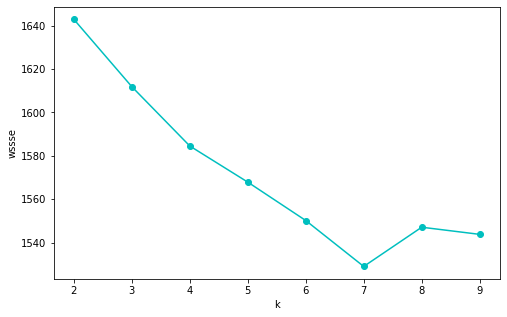

In [75]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

seed = 1
k_means_result = []
for k in range(2, 10):
    # fit model
    k_means = KMeans(k=k, seed=seed, distanceMeasure='cosine')
    model = k_means.fit(final_df)

    # compute wsse
    wssse = model.computeCost(final_df)

    # Compute silhouette
    predictions = model.transform(final_df)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)

    k_means_result.append((k, wssse, silhouette))
    print('With k = {}, Sum of Squared Error = {:.4f}, silhouette = {:.4f}'.format(k, wssse, silhouette))

k_means_result = pd.DataFrame(k_means_result, columns=['k', 'wssse', 'silhouette'])
print('')
print('Plot chart wssse with range of k')
plt.figure(figsize=(8,5))
plt.plot(k_means_result['k'], k_means_result['wssse'], 'co-')
plt.xlabel('k')
plt.ylabel('wssse')

Qua biểu đồ thay đổi wssse theo k, dựa trên elbow method lựa chọn k = 7

In [76]:
# Select k
k = 7
k_means = KMeans(k=k, seed=seed, distanceMeasure='cosine')
model = k_means.fit(final_df)
predictions = model.transform(final_df)
predictions.groupBy('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  135|
|         1|  580|
|         2|  529|
|         3|  480|
|         4|  366|
|         5|  800|
|         6|  676|
+----------+-----+



So sánh với category được tách ra ở trên, tìm xem có điểm gì chung hay không

In [77]:
predictions.crosstab('category', 'prediction').show()

+-------------------+---+---+---+---+---+---+---+
|category_prediction|  0|  1|  2|  3|  4|  5|  6|
+-------------------+---+---+---+---+---+---+---+
|             health|  4|  8|  7|  1| 90| 39|  0|
|           politics|  7|  4| 87|  5| 37| 29|  8|
|           business|  5|  0|101| 15|  5| 11|  8|
|              world|  4|  1| 47|  3|117| 11|  4|
|             others|  5|  2| 43| 11| 24| 43|  4|
|             canada|100|562|227|438| 91|665|644|
|      entertainment| 10|  3| 17|  7|  2|  2|  8|
+-------------------+---+---+---+---+---+---+---+



Qua so sánh với category:
- Các cluster đều có trọng số lớn ở canada, điều này có thể dễ hiểu vì đây là báo Canada, nên tính chất general.
- Cluster 2 có chỉ ra thêm các tính chất politics và business: covid liên quan đến chính trị và kinh tế. Đây cũng là tính chất nổi bật ở Cluster 2 có mà các nhóm khác không có.
- Cluster 4 có chỉ ra thêm các tính chất world: covid trên thế giới, tính chất này Cluster 4 có nhiều nhất trong các nhóm.
- Các tính chất đặc biệt của các cluster khác cần nghiên cứu sâu thêm để nhận biết

Vẽ wordcloud, kiểm tra xem các nhận định trên có đúng hay không

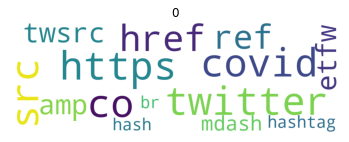

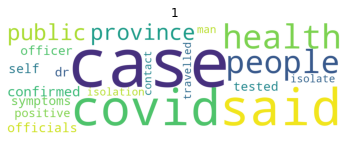

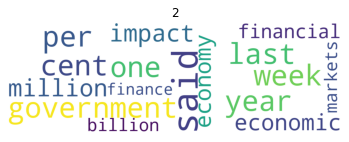

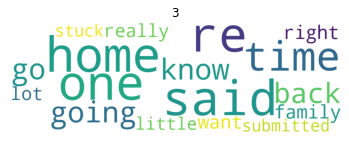

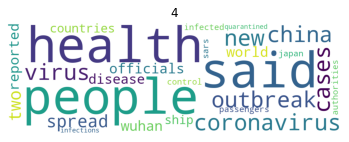

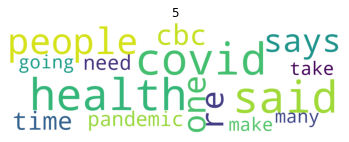

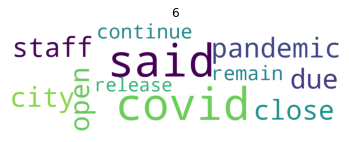

In [78]:
center = model.clusterCenters()
vocab = pre_process_pipeline_fit.stages[2].vocabulary
cluster_name = np.arange(k)
n_keywords = 50

list_keywords = []

for i in range(k):
    index = center[i].argsort()[-n_keywords:]
    keywords = []
    for word, idx in zip(vocab, range(len(vocab))):
        if idx in index:
            keywords.append(word)
    list_keywords.append(keywords)

from wordcloud import WordCloud
for keywords, name in zip(list_keywords, cluster_name):
    wordcloud = WordCloud(background_color = 'white', width = 1200, height = 400).generate(' '.join(keywords))
    plt.imshow(wordcloud)
    plt.title(name)
    plt.axis('off')
    plt.grid(False)
    plt.show()

- So sánh với các nhận định trên, Cluster 2 và 4 là khá chính xác.
- Ngoài ra có thể thấy thêm Cluster 3 nói về việc stuck working from home trong covid.
- Các Cluster khác khá chung chung và không rõ tính chất như 3 nhóm trên